In [27]:
from toolbox import *
from music21 import *


In [28]:
file = converter.parse('stalker.mid')


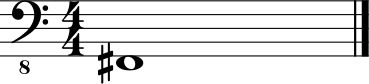

<music21.stream.Part 0x7f69808b5fd0>

In [29]:
file.parts[3].measure(77).show()
file.measure(53).parts[2]

In [30]:
def get_entropy_from_measure(file,track,measure):
    E_p = get_pitches(file.measure(measure).parts[track])
    E_r = get_rhythm(file.measure(measure).parts[track])
    E_s = get_rests(file.measure(measure).parts[track])
    total_entropy = get_list_entropy(E_p) + get_list_entropy(E_r)+ get_list_entropy(E_s)
    return total_entropy

In [50]:
import random 
a = []
for i in range(17):
    for j in range(1,78):  
        a.append(get_entropy_from_measure(file,i,j))
print(max(a))

4.737634986607822


In [288]:
file.measure(1).parts[2].show('text')

{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.instrument.Sampler 'Polysynth: Sampler'>
    {0.0} <music21.clef.BassClef>
    {0.0} <music21.tempo.MetronomeMark Quarter=112.0>
    {0.0} <music21.key.Key of C major>
    {0.0} <music21.meter.TimeSignature 1/4>
    {0.0} <music21.note.Rest quarter>


In [289]:
for a in file.parts[2].measure(1).getElementsByClass('Instrument'):
    print(type(a))

<class 'music21.instrument.Sampler'>


In [290]:
def get_entropy_dict(file):
    entropy_dict = {}AttributeError: 'Rest' object has no attribute 'pitches'
    for j in range(1,max_num_measures(file)+1):
        for i in range(len(file.parts)):
            if file.parts[i].measure(j) != None:
                entropy_dict[i,j] = get_entropy_from_measure(file,i,j)
    return entropy_dict

t0= time.time()
entropy_dict = get_entropy_dict(file)
t1 = time.time() - t0
print(t1)

SyntaxError: invalid syntax (1593561435.py, line 2)

In [291]:
from pyqubo import Binary, Constraint

def max_num_measures(file):
    return max([len(p) for p in file.parts])    

def qubo_form_from(entropy_dict):
    H = 0
    for j in range(1,max_num_measures(file)+1):
        c = 0
        o = 0
        for i in range(len(file.parts)):
            if (i,j) in entropy_dict.keys():
                c += Binary(f"x_{i}_{j}")
                o += entropy_dict[i,j]*Binary(f"x_{i}_{j}")
        H += Constraint(5*(2-c)**2, f"measure_{j}") - o
    return H.compile().to_qubo()

# def qubo_form_from(file,entropy_dict):
#     H = 0
#     for j in range(1,max_num_measures(file)+1):
#         c = 0
#         o = 0
#         for i in range(len(file.parts)):
#             if file.parts[i].measure(j) != None:
#                 c += 5*Binary(f"x_{i}_{j}")
#                 o += entropy_dict[i,j]*Binary(f"x_{i}_{j}")
#         H += Constraint((2-c)**2, f"measure_{j}") - o
#     return H.compile().to_qubo()

In [292]:
import time

qubo_form = qubo_form_from(entropy_dict)



In [293]:
print(qubo_form[1])

1540.0


In [294]:
from dwave.system import EmbeddingComposite, DWaveSampler
from neal import SimulatedAnnealingSampler
import pandas as pd
sampler = SimulatedAnnealingSampler()
sampleset = sampler.sample_qubo(qubo_form[0],
                         num_reads = 100,
                         label='Example -')
# sampleset.to_pandas_dataframe()

In [295]:
solution = sampleset.first[0]
# print(solution)

search_value = 1
found_key = [key for key, value in solution.items() if value == search_value]
# print(found_key)
ij_keys = []
for key in found_key: 
    ij_keys.append(list(map(int,key.rsplit("_")[1:3])))

check_list = np.array(ij_keys)[:,1]
unique,counts = np.unique(check_list,return_counts=True)
print('The number of selected measures is {}. We are expecting {}'.format(len(found_keys),2*77)) 
print(counts)
for i in range(1,78):
    if i in unique:
        continue
    else:
        print('Measure %{} missing'%{i})
    if counts[i] != 2:
        print('Measure %{} with %{}'%{i,counts[i]})

The number of selected measures is 154. We are expecting 154
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2]


In [296]:
a = np.array(ij_keys)
# print(a)
a_sorted = sorted(ij_keys, key=lambda element: (element[1])) 


In [297]:
new_arrange = stream.Stream()
p0 = stream.Part(id='part0')
p1 = stream.Part(id='part1')

In [298]:
for i in a_sorted:
    print(i)
    for element in file.parts[i[0]].measure(i[1]).getElementsByClass('Instrument'):
        print(file.parts[i[0]].measure(i[1]))

[8, 1]
<music21.stream.Measure 1 offset=0.0>
[9, 1]
<music21.stream.Measure 1 offset=0.0>
<music21.stream.Measure 1 offset=0.0>
[15, 2]
[8, 2]
[10, 3]
[6, 3]
[11, 4]
[7, 4]
[1, 5]
[6, 5]
[2, 6]
[5, 6]
[2, 7]
[6, 7]
[0, 8]
[14, 8]
[11, 9]
[13, 9]
[10, 10]
[11, 10]
[10, 11]
[12, 11]
[11, 12]
[1, 12]
[10, 13]
[11, 13]
[11, 14]
[1, 14]
[11, 15]
[2, 15]
[11, 16]
[2, 16]
[10, 17]
[13, 17]
[10, 18]
[11, 18]
[10, 19]
[11, 19]
[16, 20]
[4, 20]
[13, 21]
[1, 21]
[11, 22]
[1, 22]
[10, 23]
[11, 23]
[11, 24]
[2, 24]
[10, 25]
[13, 25]
[10, 26]
[6, 26]
[10, 27]
[11, 27]
[11, 28]
[5, 28]
[11, 29]
[13, 29]
[11, 30]
[7, 30]
[10, 31]
[11, 31]
[10, 32]
[11, 32]
[11, 33]
[13, 33]
[10, 34]
[11, 34]
[8, 35]
[9, 35]
[0, 36]
[8, 36]
[10, 37]
[13, 37]
[10, 38]
[7, 38]
[10, 39]
[11, 39]
[11, 40]
[6, 40]
[11, 41]
[13, 41]
[10, 42]
[2, 42]
[11, 43]
[1, 43]
[10, 44]
[1, 44]
[10, 45]
[2, 45]
[16, 46]
[2, 46]
[10, 47]
[11, 47]
[11, 48]
[4, 48]
[10, 49]
[13, 49]
[11, 50]
[7, 50]
[1, 51]
[7, 51]
[1, 52]
[8, 52]
[10, 53]

In [299]:
for i in a_sorted:
    for element in file.parts[i[0]].measure(i[1]).getElementsByClass(['Note', 'Rest']):
        if a_sorted.index(i) % 2 == 0:
            p0.append(element)
        else:
            p1.append(element)
new_arrange.insert(0,p0)
new_arrange.insert(0,p1)


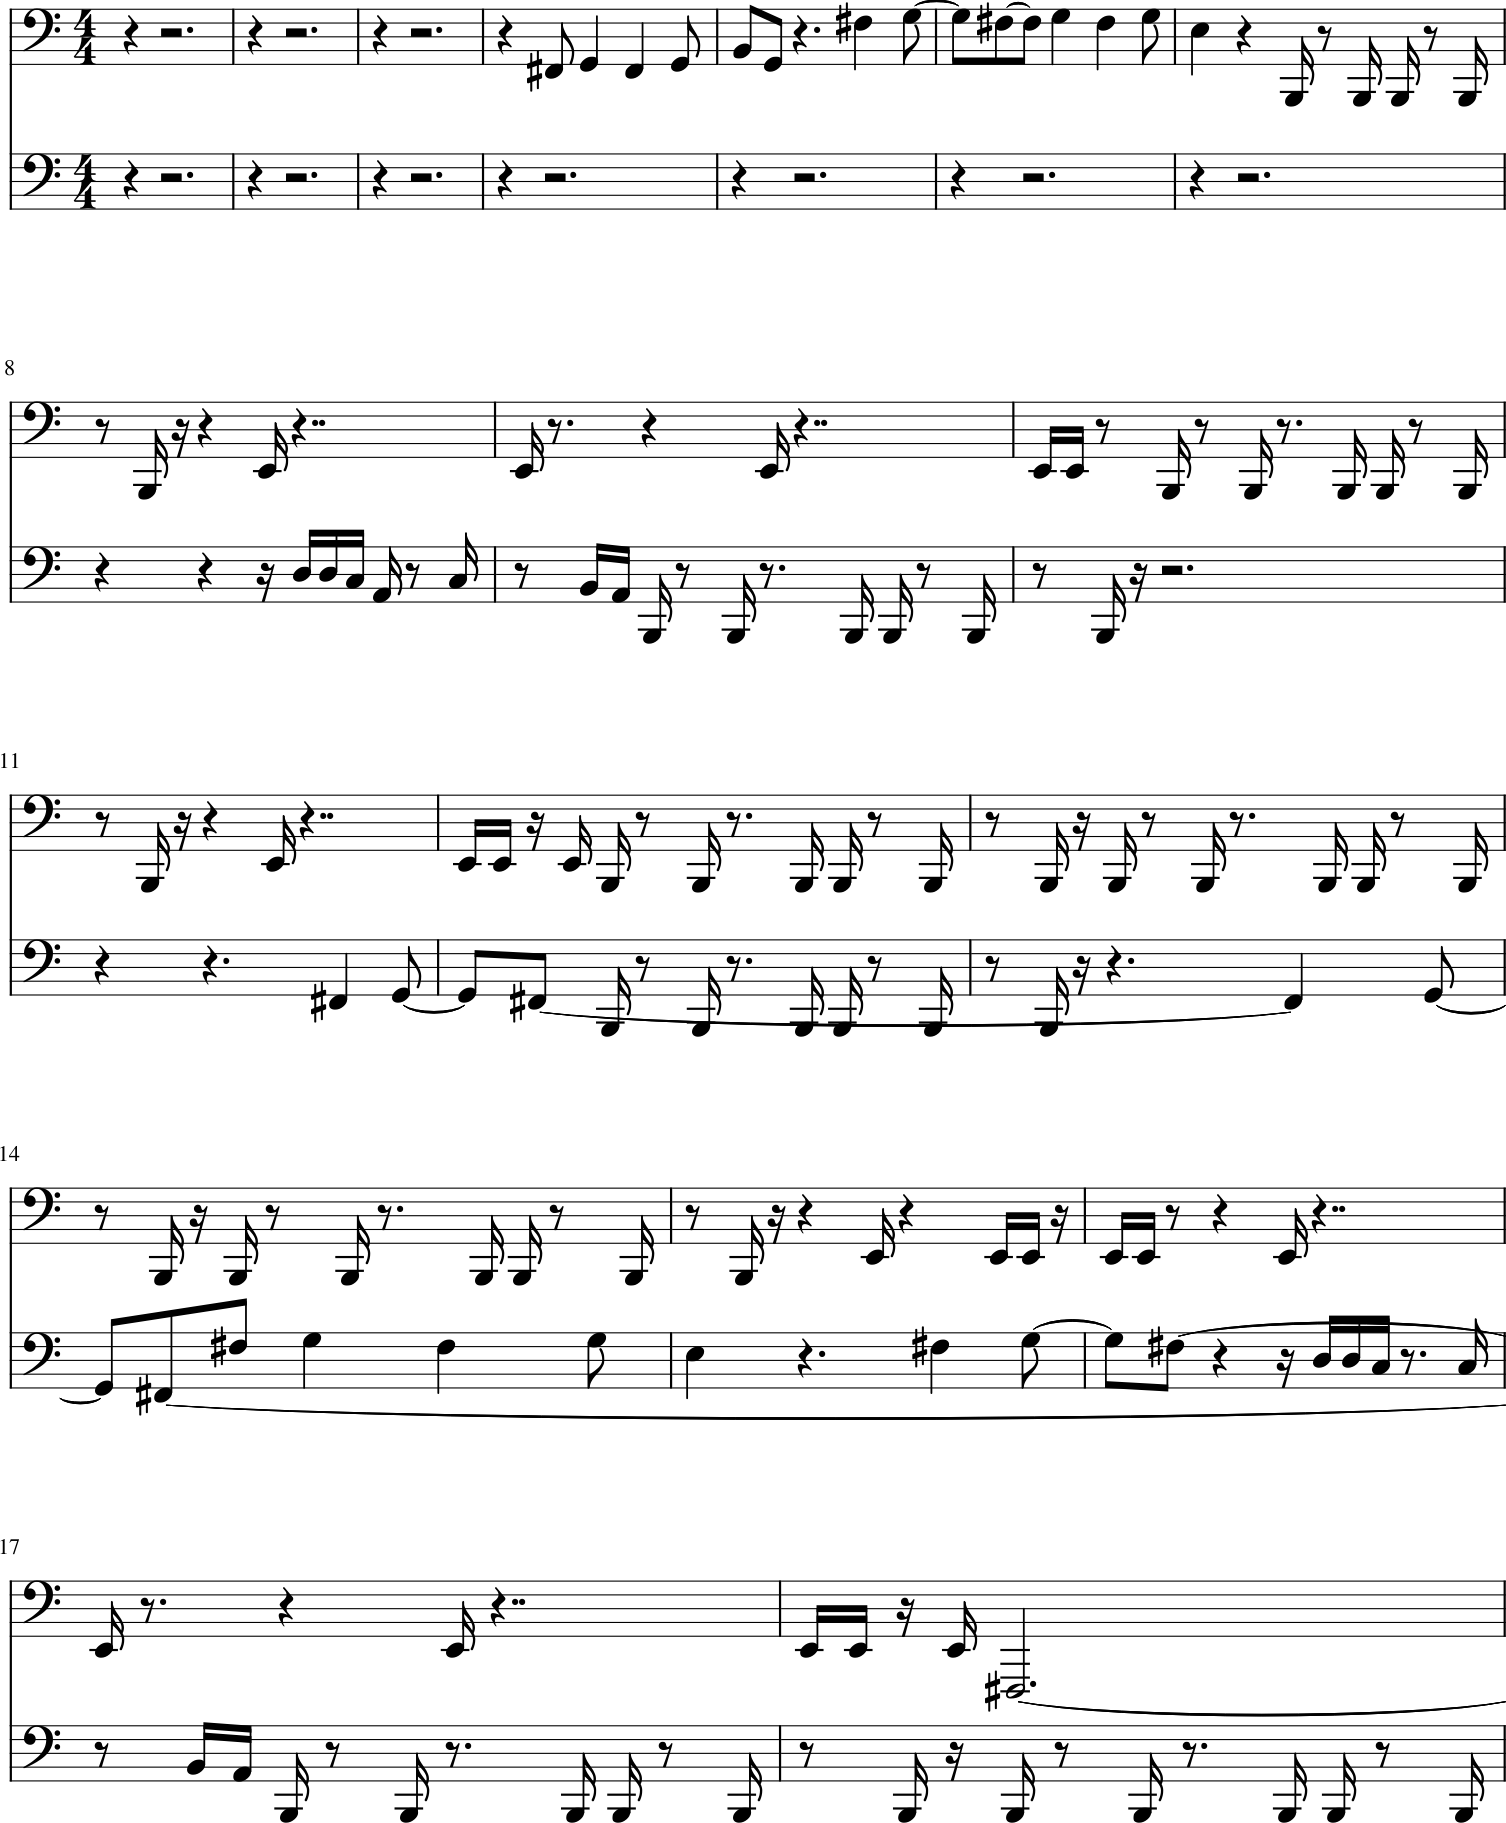

In [300]:
new_arrange.show()

In [308]:
new_arrange.write("midi", "blah.mid")

'blah.mid'

In [302]:
playe.play()